In [23]:
import yfinance as yf
from auxillary import *
from indicators import *
from datetime import date
from processData import processData
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [24]:
stocks = []
print("Enter the ticker symbols of interest (enter spacebar to exit)")
s = "  "
while s != " ":
    s = input("Ticker: ")
    if s == " " and len(stocks) == 0:
        print("Please enter a ticker symbol")
        s = "  "
        continue
    elif s == " ":
        break
    if s.upper() not in stocks:
        stocks.append(s.upper())
    

n = int(input("How many trading days in the future would you like to predict? "))



Enter the ticker symbols of interest (enter spacebar to exit)


In [ ]:
sp500_tickers = """MMM
AOS
ABT
ABBV
ABMD
ACN
ATVI
ADM
ADBE
ADP
AAP
AES
AFL
A
APD
AKAM
ALK
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AMD
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
ADI
ANSS
AON
APA
AAPL
AMAT
APTV
ANET
AJG
AIZ
T
ATO
ADSK
AZO
AVB
AVY
BKR
BALL
BAC
BBWI
BAX
BDX
WRB
SIN
BBY
BIO
TECH
BIIB
BLK
BK
BA
BKNG
BWA
BXP
BSX
BMY
AVGO
BR
BRO
BF.B
CHRW
CDNS
CZR
CPT
CPB
COF
CAH
KMX
CCL
CARR
CTLT
CAT
CBOE
CBRE
CDW
CE
CNC
CNP
CDAY
CF
CRL
SCHW
CHTR
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
C
CFG
CTXS
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
COP
ED
STZ
CEG
COO
CPRT
GLW
CTVA
COST
CTRA
CCI
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DAL
XRAY
DVN
DXCM
FANG
DLR
DFS
DISH
DIS
DG
DLTR
D
DPZ
DOV
DOW
DTE
DUK
DRE
DD
DXC
EMN
ETN
EBAY
ECL
EIX
EW
EA
ELV
LLY
EMR
ENPH
ETR
EOG
EPAM
EFX
EQIX
EQR
ESS
EL
ETSY
RE
EVRG
ES
EXC
EXPE
EXPD
EXR
XOM
FFIV
FDS
FAST
FRT
FDX
FITB
FRC
FE
FIS
FISV
FLT
FMC
F
FTNT
FTV
FBHS
FOXA
FOX
BEN
FCX
GRMN
IT
GNRC
GD
GE
GIS
GM
GPC
GILD
GL
GPN
GS
HAL
HIG
HAS
HCA
PEAK
HSIC
HSY
HES
HPE
HLT
HOLX
HD
HON
HRL
HST
HWM
HPQ
HUM
HBAN
HII
IBM
IEX
IDXX
ITW
ILMN
INCY
IR
INTC
ICE
IP
IPG
IFF
INTU
ISRG
IVZ
IQV
IRM
JBHT
JKHY
J
JNJ
JCI
JPM
JNPR
K
KDP
KEY
KEYS
KMB
KIM
KMI
KLAC
KHC
KR
LHX
LH
LRCX
LW
LVS
LDOS
LEN
LNC
LIN
LYV
LKQ
LMT
L
LOW
LUMN
LYB
MTB
MRO
MPC
MKTX
MAR
MMC
MLM
MAS
MA
MTCH
MKC
MCD
MCK
MDT
MRK
META
MET
MTD
MGM
MCHP
MU
MSFT
MAA
MRNA
MHK
MOH
TAP
MDLZ
MPWR
MNST
MCO
MS
MOS
MSI
MSCI
NDAQ
NTAP
NFLX
NWL
NEM
NWSA
NWS
NEE
NLSN
NKE
NI
NDSN
NSC
NTRS
NOC
NLOK
NCLH
NRG
NUE
NVDA
NVR
NXPI
ORLY
OXY
ODFL
OMC
ON
OKE
ORCL
OGN
OTIS
PCAR
PKG
PARA
PH
PAYX
PAYC
PYPL
PENN
PNR
PEP
PKI
PFE
PM
PSX
PNW
PXD
PNC
POOL
PPG
PPL
PFG
PG
PGR
PLD
PRU
PEG
PTC
PSA
PHM
PVH
QRVO
PWR
QCOM
DGX
RL
RJF
RTX
O
REG
REGN
RF
RSG
RMD
RHI
ROK
ROL
ROP
ROST
RCL
SPGI
CRM
SBAC
SLB
STX
SEE
SRE
NOW
SHW
SBNY
SPG
SWKS
SJM
SNA
SEDG
SO
LUV
SWK
SBUX
STT
STE
SYK
SIVB
SYF
SNPS
SYY
TMUS
TROW
TTWO
TPR
TGT
TEL
TDY
TFX
TER
TSLA
TXN
TXT
TMO
TJX
TSCO
TT
TDG
TRV
TRMB
TFC
TWTR
TYL
TSN
USB
UDR
ULTA
UNP
UAL
UPS
URI
UNH
UHS
VLO
VTR
VRSN
VRSK
VZ
VRTX
VFC
VTRS
VICI
V
VNO
VMC
WAB
WBA
WMT
WBD
WM
WAT
WEC
WFC
WELL
WST
WDC
WRK
WY
WHR
WMB
WTW
GWW
WYNN
XEL
XYL
YUM
ZBRA
ZBH
ZION
ZTS"""


In [ ]:
tickers = sp500_tickers.split("\n")
np.random.shuffle(tickers)

In [25]:
prices, general, target, cluster, pc = processData(stocks[0], n)

In [33]:
training_df = pd.concat([prices, general, target], axis = 1)

In [42]:
def trainTestSplit(df, train_proportion):
    split = int(train_proportion*len(df))
    train = df.iloc[:split]
    test = df.iloc[split:]
    return train,test

def cvSplit(df, k):
    split = len(df) // k
    train = []
    val = []
    for i in range(1,k+1):
        train_ = df[:split*i]
        val_ = df[split*i:split*(i+1)]
        train.append(train_)
        val.append(val_)

    return train, val

In [ ]:
# RNN?LSTM

In [5]:
training_set = pc.iloc[:, :2]

In [7]:
y = target["Future_Price"]

In [8]:
training_set = pd.concat([prices["Close"], training_set, y], axis = 1).dropna().values

In [18]:
x_train = []
y_train = []
x_test = []
y_test = []

for i in range(60, int(0.8*len(training_set) // 1)):
    x_train.append(training_set[i-60:i, 0:3])
    y_train.append(training_set[i, 3])

for i in range(int(0.8*len(training_set) // 1), len(training_set)):
    x_test.append(training_set[i-60:i, 0:3])
    y_test.append(training_set[i, 3])

X_train, y_train, X_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


In [10]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [19]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1:])))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
231/231 [==============================] - 39s 104ms/step - loss: 316.8395
Epoch 2/50
231/231 [==============================] - 23s 102ms/step - loss: 122.0588
Epoch 3/50
231/231 [==============================] - 23s 101ms/step - loss: 64.3567
Epoch 4/50
231/231 [==============================] - 25s 106ms/step - loss: 42.9952
Epoch 5/50
231/231 [==============================] - 24s 105ms/step - loss: 30.9985
Epoch 6/50
231/231 [==============================] - 23s 101ms/step - loss: 22.8450
Epoch 7/50
231/231 [==============================] - 24s 103ms/step - loss: 16.8521
Epoch 8/50
231/231 [==============================] - 23s 101ms/step - loss: 13.5245
Epoch 9/50
231/231 [==============================] - 24s 102ms/step - loss: 11.2847
Epoch 10/50
231/231 [==============================] - 24s 102ms/step - loss: 9.6337
Epoch 11/50
231/231 [==============================] - 23s 101ms/step - loss: 8.9902
Epoch 12/50
231/231 [==============================] - 24s 102m

In [20]:
predicted_stock_price = model.predict(X_test)

58/58 [==============================] - 5s 34ms/step


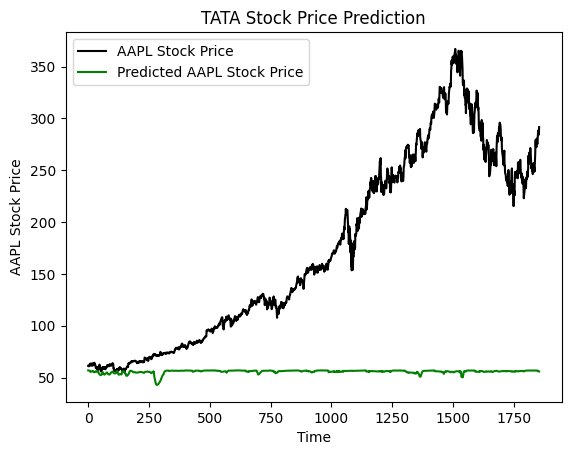

In [22]:
plt.plot(y_test, color = 'black', label = 'AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()